In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R /content/vinbigdata/test/* /content/drive/MyDrive/XrayTestImage

In [1]:
!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!pip install -q kaggle

In [3]:
!kaggle datasets download -d awsaf49/vinbigdata-original-image-dataset

100% 24.3G/24.3G [06:52<00:00, 38.5MB/s]
100% 24.3G/24.3G [06:52<00:00, 63.1MB/s]


In [4]:
!unzip -q vinbigdata-original-image-dataset.zip

In [30]:
!pip install tensorflow_addons pydicom

     |████████████████████████████████| 1.9MB 5.4MB/s 


In [56]:
# !/opt/conda/bin/python3.7 -m pip install -q --upgrade pip      # Upgrade PIP
!pip install -q pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg # Install/Upgrade PyDicom Dependencies

# Machine Learning and Data Science Imports
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_hub as hub
from skimage import exposure
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np
import scipy

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

# PRESETS
FIG_FONT = dict(family="Helvetica, Arial", size=14, color="#7f7f7f")
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 15)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

# Other Imports
# from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.notebook import tqdm
# import pydicom

# NOTEBOOK SETUP


In [124]:
DATA_DIR = "/content/vinbigdata"

# Define the paths to the training and testing dicom folders respectively
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Capture all the relevant full train/test paths
TRAIN_DICOM_PATHS = [os.path.join(TRAIN_DIR, f_name) for f_name in os.listdir(TRAIN_DIR)]
TEST_DICOM_PATHS = [os.path.join(TEST_DIR, f_name) for f_name in os.listdir(TEST_DIR)]
print(f"\n... The number of training files is {len(TRAIN_DICOM_PATHS)} ...")
print(f"... The number of testing files is {len(TEST_DICOM_PATHS)} ...")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")

# Create the relevant dataframe objects
train_df = pd.read_csv(TRAIN_CSV)


print("\n\nTRAIN DATAFRAME\n\n")
display(train_df.head(3))


... The number of training files is 15000 ...
... The number of testing files is 3000 ...


TRAIN DATAFRAME




image_id    class_name  ...  width height
0  50a418190bc3fb1ef1633bf9678929b3    No finding  ...   2332   2580
1  21a10246a5ec7af151081d0cd6d65dc9    No finding  ...   2954   3159
2  9a5094b2563a1ef3ff50dc5c7ff71345  Cardiomegaly  ...   2080   2336

[3 rows x 10 columns]

In [16]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    """ Convert dicom file to numpy array 
    
    Args:
        path (str): Path to the dicom file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to apply monochrome fix
        
    Returns:
        Numpy array of the respective dicom file 
        
    """
    # Use the pydicom library to read the dicom file
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to 
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # The XRAY may look inverted
    #   - If we want to fix this we can
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    # Normalize the image array and return
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def plot_image(img, title="", figsize=(8,8), cmap=None):
    """ Function to plot an image to save a bit of time """
    plt.figure(figsize=figsize)
    
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        img
        plt.imshow(img)
        
    plt.title(title, fontweight="bold")
    plt.axis(False)
    plt.show()
    
def get_image_id(path):
    """ Function to return the image-id from a path """
    return path.rsplit("/", 1)[1].rsplit(".", 1)[0]

def create_fractional_bbox_coordinates(row):
    """ Function to return bbox coordiantes as fractions from DF row """
    frac_x_min = row["x_min"]/row["img_width"]
    frac_x_max = row["x_max"]/row["img_width"]
    frac_y_min = row["y_min"]/row["img_height"]
    frac_y_max = row["y_max"]/row["img_height"]
    return frac_x_min, frac_x_max, frac_y_min, frac_y_max

def draw_bboxes(img, tl, br, rgb, label="", label_location="tl", opacity=0.1, line_thickness=0):
    """ TBD 
    
    Args:
        TBD
        
    Returns:
        TBD 
    """
    rect = np.uint8(np.ones((br[1]-tl[1], br[0]-tl[0], 3))*rgb)
    sub_combo = cv2.addWeighted(img[tl[1]:br[1],tl[0]:br[0],:], 1-opacity, rect, opacity, 1.0)    
    img[tl[1]:br[1],tl[0]:br[0],:] = sub_combo

    if line_thickness>0:
        img = cv2.rectangle(img, tuple(tl), tuple(br), rgb, line_thickness)
        
    if label:
        # DEFAULTS
        FONT = cv2.FONT_HERSHEY_SIMPLEX
        FONT_SCALE = 1.666
        FONT_THICKNESS = 3
        FONT_LINE_TYPE = cv2.LINE_AA
        
        if type(label)==str:
            LABEL = label.upper().replace(" ", "_")
        else:
            LABEL = f"CLASS_{label:02}"
        
        text_width, text_height = cv2.getTextSize(LABEL, FONT, FONT_SCALE, FONT_THICKNESS)[0]
        
        label_origin = {"tl":tl, "br":br, "tr":(br[0],tl[1]), "bl":(tl[0],br[1])}[label_location]
        label_offset = {
            "tl":np.array([0, -10]), "br":np.array([-text_width, text_height+10]), 
            "tr":np.array([-text_width, -10]), "bl":np.array([0, text_height+10])
        }[label_location]
        img = cv2.putText(img, LABEL, tuple(label_origin+label_offset), 
                          FONT, FONT_SCALE, rgb, FONT_THICKNESS, FONT_LINE_TYPE)
    
    return img

In [91]:
df = train_df.image_id.value_counts().to_frame(name="count").reset_index()

fig = px.histogram(df, x='count',y='index',
                   log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER PATIENT  <i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Images</b>",
                  yaxis_title="<b>Count of All Object Annotations</b>",
                  font=FIG_FONT,)
fig.show()

In [102]:
df=train_df.groupby('image_id')["class_name"].unique().apply(lambda x: len(x)).to_frame(name="count").reset_index()
fig = px.histogram(df, x='count',y='image_id',
             log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
             labels={"value":"Number of Unique Abnormalities"},
             title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER PATIENT  <i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )
fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique Abnormalities</b>",
                  yaxis_title="<b>Count of Unique Patients</b>",
                  font=FIG_FONT,)
fig.show()

In [104]:
df = train_df.class_name.value_counts().sort_index().to_frame(name="count").reset_index()
df

index  count
0   Aortic enlargement   7162
1          Atelectasis    279
2        Calcification    960
3         Cardiomegaly   5427
4        Consolidation    556
5                  ILD   1000
6         Infiltration   1247
7         Lung Opacity   2483
8           No finding  31818
9          Nodule/Mass   2580
10        Other lesion   2203
11    Pleural effusion   2476
12  Pleural thickening   4842
13        Pneumothorax    226
14  Pulmonary fibrosis   4655

In [110]:
fig = px.bar(df, x='index',y='count',
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)
fig.update_layout(
                  font=FIG_FONT,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

In [112]:
fig = px.histogram(train_df, x="rad_id", color="rad_id",opacity=0.85,
                   labels={"rad_id":"Radiologist ID"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER RADIOLOGIST</b>",
                   ).update_xaxes(categoryorder="total descending")
fig.update_layout(
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT,)
fig.show()

In [114]:
# Create dictionary mappings
int_2_str = {i:train_df[train_df["class_id"]==i].iloc[0]["class_name"] for i in range(15)}
str_2_int = {v:k for k,v in int_2_str.items()}
int_2_clr = {str_2_int[k]:LABEL_COLORS[i] for i,k in enumerate(sorted(str_2_int.keys()))}

print("\n... Dictionary Mapping Class Integer to Class String Representation [int_2_str]...\n")
display(int_2_str)

print("\n... Dictionary Mapping Class String to Class Integer Representation [str_2_int]...\n")
display(str_2_int)

print("\n... Dictionary Mapping Class Integer to Color Representation [str_2_clr]...\n")
display(int_2_clr)

print("\n... Head of Train Dataframe After Dropping The Class Name Column...\n")
train_df.drop(columns=["class_name"], inplace=True)
display(train_df.head(5))


... Dictionary Mapping Class Integer to Class String Representation [int_2_str]...



{0: 'Aortic enlargement',
 1: 'Atelectasis',
 2: 'Calcification',
 3: 'Cardiomegaly',
 4: 'Consolidation',
 5: 'ILD',
 6: 'Infiltration',
 7: 'Lung Opacity',
 8: 'Nodule/Mass',
 9: 'Other lesion',
 10: 'Pleural effusion',
 11: 'Pleural thickening',
 12: 'Pneumothorax',
 13: 'Pulmonary fibrosis',
 14: 'No finding'}


... Dictionary Mapping Class String to Class Integer Representation [str_2_int]...



{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'No finding': 14,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13}


... Dictionary Mapping Class Integer to Color Representation [str_2_clr]...



{0: 'rgb(193, 39, 74)',
 1: 'rgb(221, 74, 76)',
 2: 'rgb(240, 103, 68)',
 3: 'rgb(249, 142, 82)',
 4: 'rgb(253, 181, 103)',
 5: 'rgb(254, 212, 129)',
 6: 'rgb(254, 236, 159)',
 7: 'rgb(255, 255, 190)',
 8: 'rgb(214, 238, 155)',
 9: 'rgb(177, 223, 163)',
 10: 'rgb(134, 207, 165)',
 11: 'rgb(94, 185, 169)',
 12: 'rgb(61, 149, 184)',
 13: 'rgb(68, 113, 178)',
 14: 'rgb(239, 249, 166)'}


... Head of Train Dataframe After Dropping The Class Name Column...



image_id  class_id rad_id  ...   y_max  width  height
0  50a418190bc3fb1ef1633bf9678929b3        14    R11  ...     NaN   2332    2580
1  21a10246a5ec7af151081d0cd6d65dc9        14     R7  ...     NaN   2954    3159
2  9a5094b2563a1ef3ff50dc5c7ff71345         3    R10  ...  1831.0   2080    2336
3  051132a778e61a86eb147c7c6f564dfe         0    R10  ...  1019.0   2304    2880
4  063319de25ce7edb9b1c6b8881290140        14    R10  ...     NaN   2540    3072

[5 rows x 9 columns]

In [115]:
fig = go.Figure()

for i in range(15):
    fig.add_trace(go.Histogram(
        x=train_df[train_df["class_id"]==i]["rad_id"],
        marker_color=int_2_clr[i],
        name=f"<b>{int_2_str[i]}</b>"))

fig.update_xaxes(categoryorder="total descending")
fig.update_layout(title="<b>DISTRIBUTION OF CLASS LABEL ANNOTATIONS BY RADIOLOGIST</b>",
                  barmode='stack',
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT,)
fig.show()

fig = go.Figure()
for i in range(15):
    fig.add_trace(go.Histogram(
        x=train_df[(train_df["class_id"]==i) & (~train_df["rad_id"].isin(["R8","R9","R10"]))]["rad_id"],
        marker_color=int_2_clr[i],
        name=f"<b>{int_2_str[i]}</b>"))

fig.update_xaxes(categoryorder="total descending")
fig.update_layout(title="<b>DISTRIBUTION OF CLASS LABEL ANNOTATIONS BY RADIOLOGIST   " \
                  "<i><sub>(EXCLUDING TOP 3 RADIOLOGISTS --> R8, R9 & R10)</sub></i></b>",
                  barmode='stack',
                  xaxis_title="<b>Radiologist ID</b>",
                  yaxis_title="<b>Number of Annotations Made</b>",
                  font=FIG_FONT,)
fig.show()

In [123]:
train_df

image_id  class_id rad_id  ...   y_max  width  height
0      50a418190bc3fb1ef1633bf9678929b3        14    R11  ...     NaN   2332    2580
1      21a10246a5ec7af151081d0cd6d65dc9        14     R7  ...     NaN   2954    3159
2      9a5094b2563a1ef3ff50dc5c7ff71345         3    R10  ...  1831.0   2080    2336
3      051132a778e61a86eb147c7c6f564dfe         0    R10  ...  1019.0   2304    2880
4      063319de25ce7edb9b1c6b8881290140        14    R10  ...     NaN   2540    3072
...                                 ...       ...    ...  ...     ...    ...     ...
67909  936fd5cff1c058d39817a08f58b72cae        14     R1  ...     NaN   2444    3200
67910  ca7e72954550eeb610fe22bf0244b7fa        14     R1  ...     NaN   1994    2430
67911  aa17d5312a0fb4a2939436abca7f9579        14     R8  ...     NaN   2048    2500
67912  4b56bc6d22b192f075f13231419dfcc8         3     R8  ...  1311.0   1968    2040
67913  5e272e3adbdaafb07a7e84a9e62b1a4c        14    R16  ...     NaN   2048    2500

[67914 rows x 9 columns]

In [120]:
def plot_example(idx_list):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(3):
        image_id = train_df.loc[idx_list[i], 'image_id']
        img = cv2.imread('/content/vinbigdata/train/'+image_id+'.jpg')
        # data_file = dicom.dcmread(path+'train/'+image_id+'.dicom')
        # img = data_file.pixel_array
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(train_df.loc[idx_list[i], 'class_name'])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if train_df.loc[idx_list[i], 'class_name'] != 'No finding':
            bbox = [train_df.loc[idx_list[i], 'x_min'],
                    train_df.loc[idx_list[i], 'y_min'],
                    train_df.loc[idx_list[i], 'x_max'],
                    train_df.loc[idx_list[i], 'y_max']]
            p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                             bbox[2]-bbox[0],
                                             bbox[3]-bbox[1],
                                             ec='r', fc='none', lw=2.)
            axs[i].add_patch(p)
     

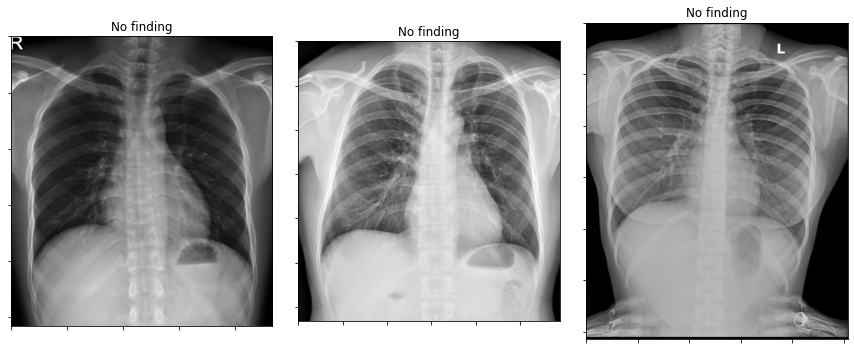

In [125]:
idx_list = train_df[train_df['class_id']==14][0:3].index.values
plot_example(idx_list)

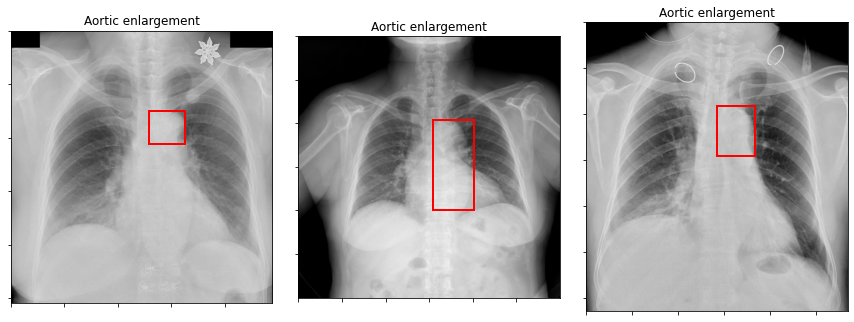

In [127]:
idx_list = train_df[train_df['class_id']==0][9:12].index.values
plot_example(idx_list)

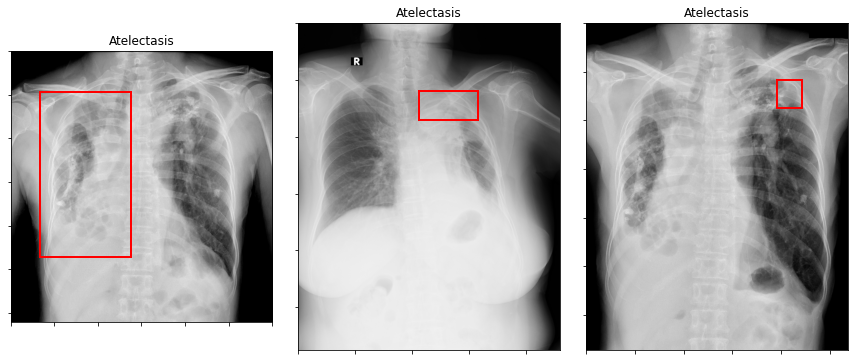

In [128]:
idx_list = train_df[train_df['class_id']==1][0:3].index.values
plot_example(idx_list)

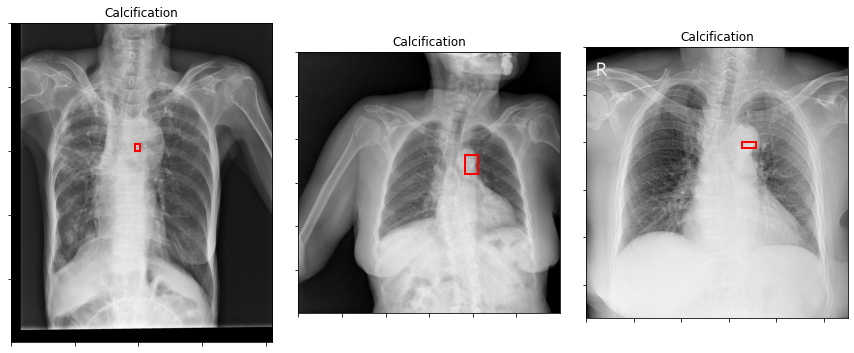

In [129]:
idx_list = train_df[train_df['class_id']==2][0:3].index.values
plot_example(idx_list)

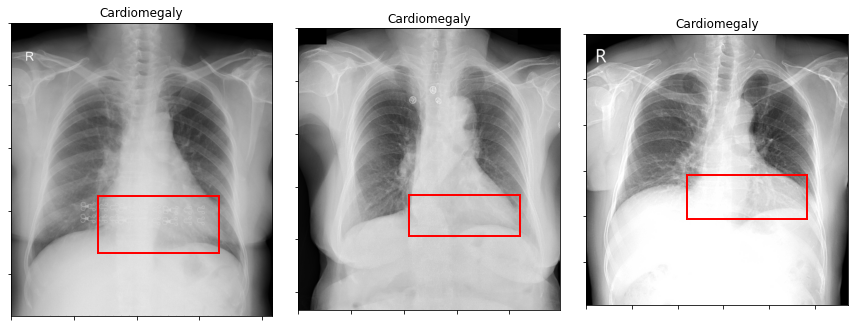

In [130]:
idx_list = train_df[train_df['class_id']==3][0:3].index.values
plot_example(idx_list)

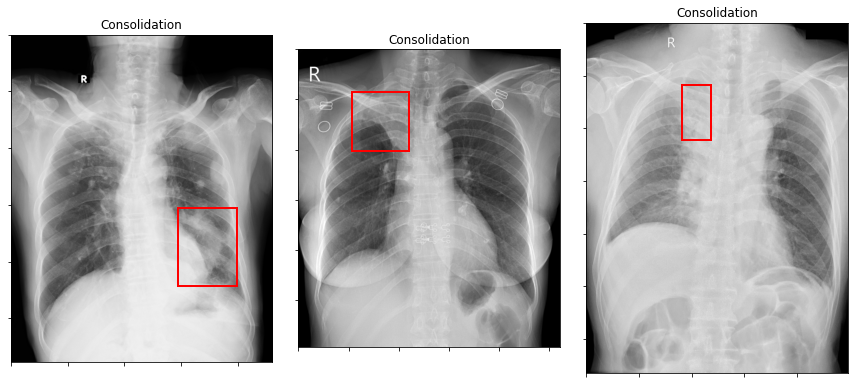

In [131]:
idx_list = train_df[train_df['class_id']==4][0:3].index.values
plot_example(idx_list)

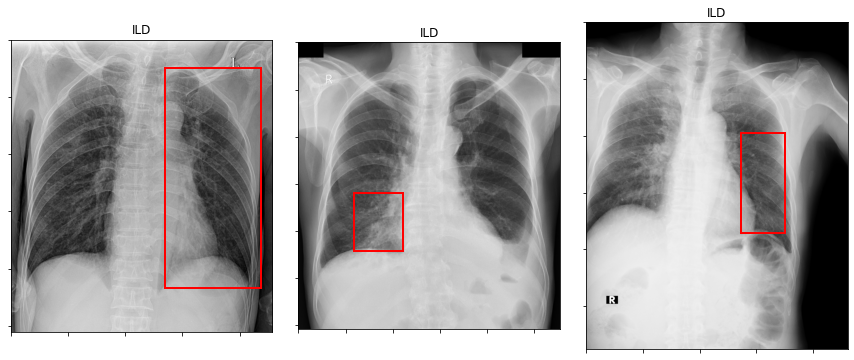

In [132]:
idx_list = train_df[train_df['class_id']==5][0:3].index.values
plot_example(idx_list)

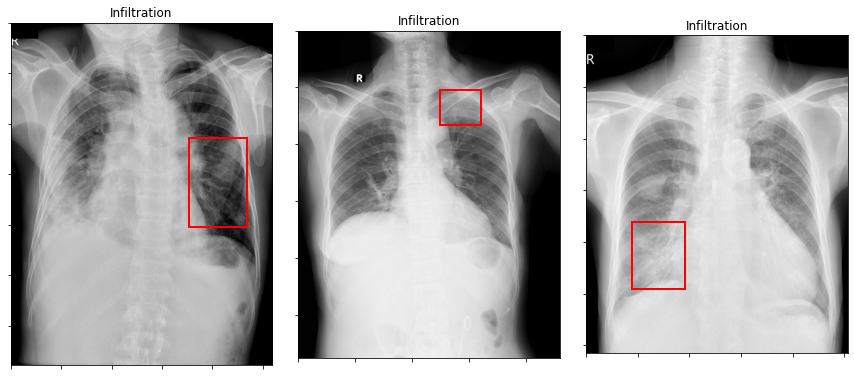

In [133]:
idx_list = train_df[train_df['class_id']==6][0:3].index.values
plot_example(idx_list)

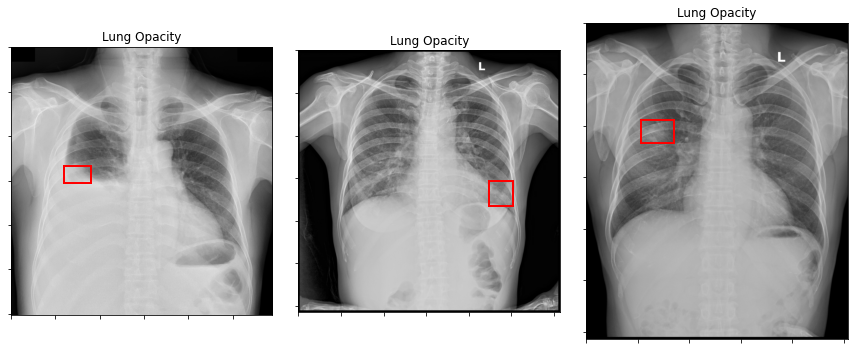

In [134]:
idx_list = train_df[train_df['class_id']==7][0:3].index.values
plot_example(idx_list)

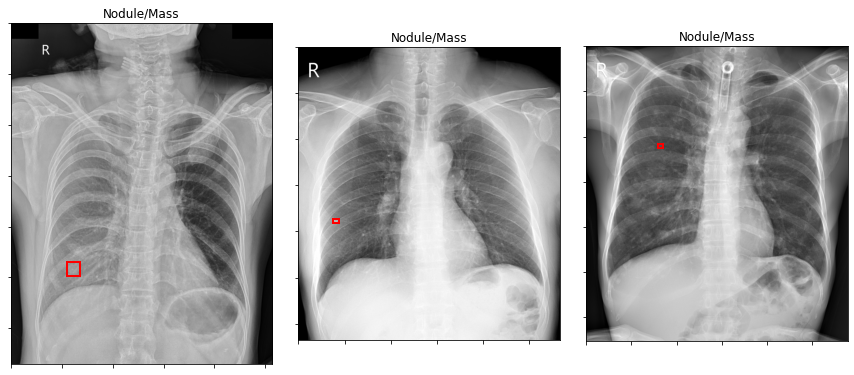

In [135]:
idx_list = train_df[train_df['class_id']==8][0:3].index.values
plot_example(idx_list)

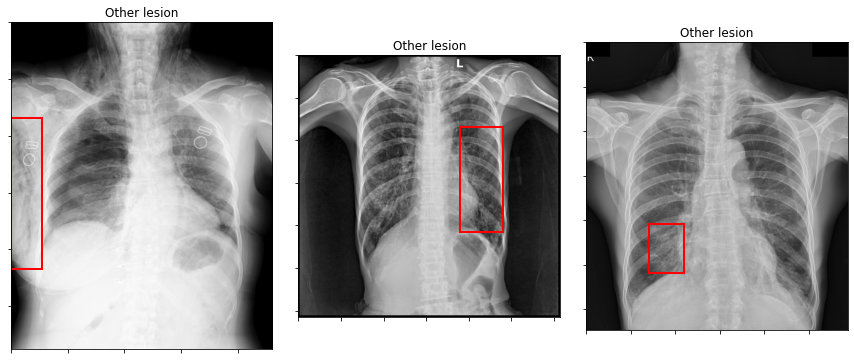

In [136]:
idx_list = train_df[train_df['class_id']==9][0:3].index.values
plot_example(idx_list)

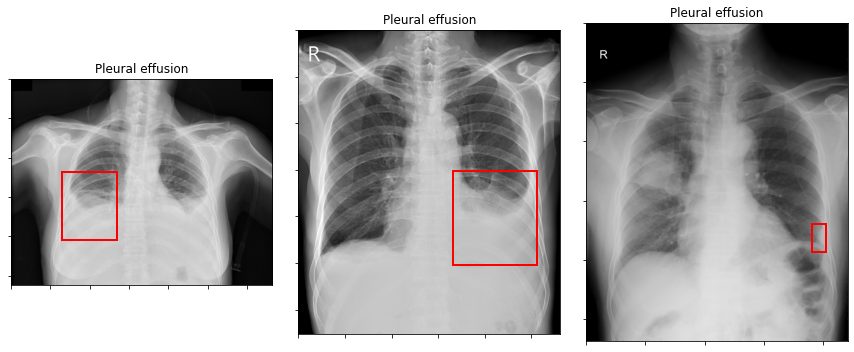

In [137]:
idx_list = train_df[train_df['class_id']==10][0:3].index.values
plot_example(idx_list)

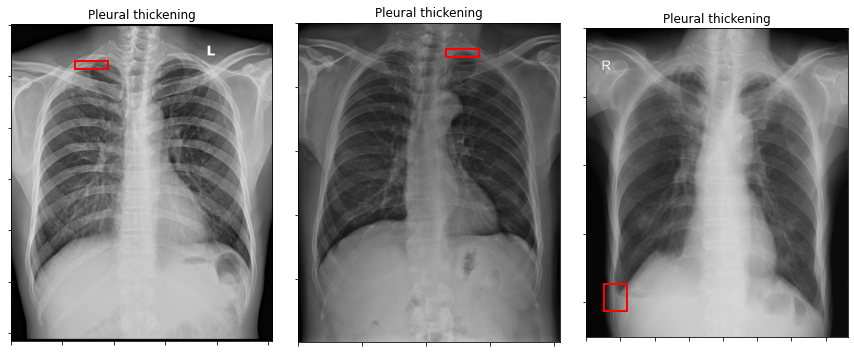

In [138]:
idx_list = train_df[train_df['class_id']==11][0:3].index.values
plot_example(idx_list)

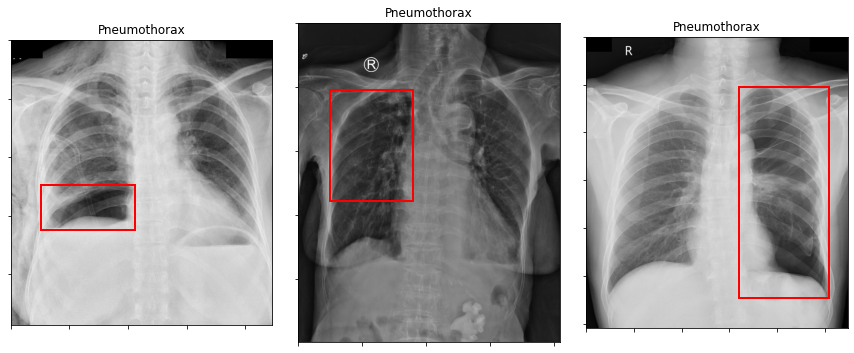

In [139]:
idx_list = train_df[train_df['class_id']==12][1:4].index.values
plot_example(idx_list)

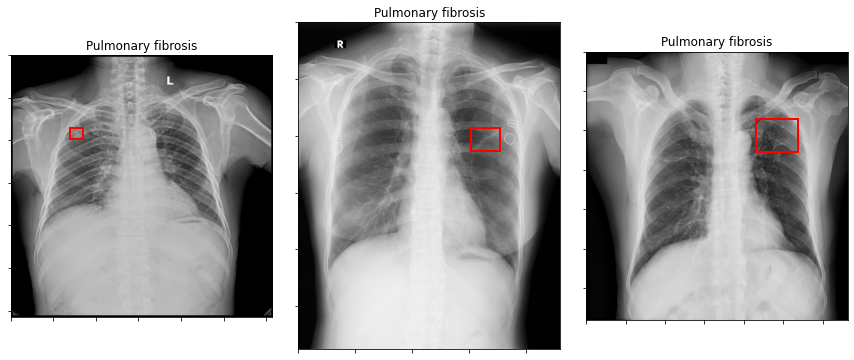

In [140]:
idx_list = train_df[train_df['class_id']==13][3:6].index.values
plot_example(idx_list)